In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re
from thefuzz import fuzz, process
from collections import defaultdict

In [52]:
df = pd.read_csv("../data/raw/Building_Permits__Addition_Alteration_20250305.csv")
df

/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/3816569170.py:1: DtypeWarning: Columns (29,39,40,41,42,43,44,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/Building_Permits__Addition_Alteration_20250305.csv")


,Record Number,Address,Address for Mapping,Latitude,Longitude,Status,Submit Date,Issue Date,Units Added,Units Removed,...,Certificate of Occupancy Required,Board of Zoning Appeal (BZA) Case Number,Planning Board Special Permit Number,BZA Case,Planning Board Special Permit,record type id,maplot number,bicycle parking change,ID field,Viewpoint ID
0,62244,"304 Vassar St, Cambridge, MA 02139","304 Vassar St\nCambridge, MA 02139\n(42.3552, ...",42.354803,-71.104827,Active,12/12/2019,01/07/2020,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,62-41,No,62244,83673
1,62595,"174 Alewife Brook Pkwy, Cambridge, MA 02138","174 Alewife Brook Pkwy\nCambridge, MA 02138\n(...",42.390588,-71.140620,Active,12/16/2019,12/23/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,265C-25,No,62595,83964
2,62708,"1493 Cambridge St, Cambridge, MA 02139","1493 Cambridge St\nCambridge, MA 02139\n(42.37...",42.374425,-71.104437,Active,12/19/2019,01/10/2020,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,111-60,No,62708,84427
3,53472,"151 Magazine St, Cambridge, MA 02139","151 Magazine St\nCambridge, MA 02139\n(42.358,...",42.358092,-71.112429,Complete,08/08/2019,08/12/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,100-45,No,53472,68560
4,53646,"292 Columbia St, Unit 2, Cambridge, MA 02141","292 Columbia St\nCambridge, MA 02141\n(42.3703...",42.370272,-71.095866,Active,08/12/2019,08/29/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,79-100,No,53646,68835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11873,60748,"105 Broadway, Cambridge, MA 02142","105 Broadway\nCambridge, MA 02142\n(42.36414, ...",42.364383,-71.087858,Active,11/18/2019,11/20/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,43-82,No,60748,80918
11874,61701,"377 Putnam Ave, Cambridge, Ma 02139","377 Putnam Ave\nCambridge, Ma 02139\n(42.36077...",42.368296,-71.101828,Active,12/04/2019,12/26/2019,NaN,NaN,...,NaN,BZA-017097-2019,2019-01826238,True,True,NaN,NaN,No,61701,82703
11875,61881,"9 Brookline St, Cambridge, MA 02139","9 Brookline St\nCambridge, MA 02139\n(42.36376...",42.363788,-71.101715,Active,12/06/2019,01/13/2020,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,93-81,No,61881,83029
11876,62039,"99 Magazine St, Unit 1, Cambridge, MA 02139","99 Magazine St\nCambridge, MA 02139\n(42.36039...",42.360474,-71.109815,Complete,12/09/2019,12/10/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,101-198-1,No,62039,83230


In [53]:
# Clean Columns
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")  #Convert colummns to lowercase
df

,record_number,address,address_for_mapping,latitude,longitude,status,submit_date,issue_date,units_added,units_removed,...,certificate_of_occupancy_required,board_of_zoning_appeal_(bza)_case_number,planning_board_special_permit_number,bza_case,planning_board_special_permit,record_type_id,maplot_number,bicycle_parking_change,id_field,viewpoint_id
0,62244,"304 Vassar St, Cambridge, MA 02139","304 Vassar St\nCambridge, MA 02139\n(42.3552, ...",42.354803,-71.104827,Active,12/12/2019,01/07/2020,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,62-41,No,62244,83673
1,62595,"174 Alewife Brook Pkwy, Cambridge, MA 02138","174 Alewife Brook Pkwy\nCambridge, MA 02138\n(...",42.390588,-71.140620,Active,12/16/2019,12/23/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,265C-25,No,62595,83964
2,62708,"1493 Cambridge St, Cambridge, MA 02139","1493 Cambridge St\nCambridge, MA 02139\n(42.37...",42.374425,-71.104437,Active,12/19/2019,01/10/2020,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,111-60,No,62708,84427
3,53472,"151 Magazine St, Cambridge, MA 02139","151 Magazine St\nCambridge, MA 02139\n(42.358,...",42.358092,-71.112429,Complete,08/08/2019,08/12/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,100-45,No,53472,68560
4,53646,"292 Columbia St, Unit 2, Cambridge, MA 02141","292 Columbia St\nCambridge, MA 02141\n(42.3703...",42.370272,-71.095866,Active,08/12/2019,08/29/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,79-100,No,53646,68835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11873,60748,"105 Broadway, Cambridge, MA 02142","105 Broadway\nCambridge, MA 02142\n(42.36414, ...",42.364383,-71.087858,Active,11/18/2019,11/20/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,43-82,No,60748,80918
11874,61701,"377 Putnam Ave, Cambridge, Ma 02139","377 Putnam Ave\nCambridge, Ma 02139\n(42.36077...",42.368296,-71.101828,Active,12/04/2019,12/26/2019,NaN,NaN,...,NaN,BZA-017097-2019,2019-01826238,True,True,NaN,NaN,No,61701,82703
11875,61881,"9 Brookline St, Cambridge, MA 02139","9 Brookline St\nCambridge, MA 02139\n(42.36376...",42.363788,-71.101715,Active,12/06/2019,01/13/2020,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,93-81,No,61881,83029
11876,62039,"99 Magazine St, Unit 1, Cambridge, MA 02139","99 Magazine St\nCambridge, MA 02139\n(42.36039...",42.360474,-71.109815,Complete,12/09/2019,12/10/2019,NaN,NaN,...,NaN,NaN,NaN,False,False,NaN,101-198-1,No,62039,83230


In [54]:
df.dtypes

record_number               int64
address                    object
address_for_mapping        object
latitude                  float64
longitude                 float64
                           ...   
record_type_id            float64
maplot_number              object
bicycle_parking_change     object
id_field                    int64
viewpoint_id                int64
Length: 91, dtype: object

In [55]:
df.columns

Index(['record_number', 'address', 'address_for_mapping', 'latitude',
       'longitude', 'status', 'submit_date', 'issue_date', 'units_added',
       'units_removed', 'number_of_units', 'change_in_units_(increase)',
       'change_in_units_(decrease)', 'change_in_units', 'current_property_use',
       'proposed_property_use', 'change_in_property_use', 'building_cost',
       'electrical_cost', 'plumbing_cost', 'gas_cost', 'hvac_cost',
       'total_cost', 'final_cost', 'fire_prevention_cost', 'description',
       'isd_description', 'size_of_new_addition',
       'change_in_floor_area_or_dimensions', 'change_in_exterior',
       'change_at_least_25,000_square_feet', 'change_in_food_establishment',
       'change_in_bicycle_parking', 'energy_compliance_option',
       'leed_certification', 'home_energy_rating_(hers)',
       'industrial_sewer_connection_units',
       'commercial_sewer_connection_units',
       'residential_sewer_connection_units',
       'discharge_to_sewer_or_storm_w

In [56]:
df["description"]

0        Complete interior and limited exterior renovat...
1           demo of interior walls / carpet / tile and ACT
2        Replacement or 7-fire door due to damaged door...
3        Remove and replace front porch stair and stair...
4        Kitchen renovation,  wall  finishing and paint...
                               ...                        
11873    Replacement of existing penthouse emergency ge...
11874    Installation of concrete foundations for new t...
11875    install a metal stud wall wityh 5/8 fire code ...
11876    Renovate existing bathroom. New plumbing fixtu...
11877    Replace railings and 2 columns on 1st floor fr...
Name: description, Length: 11878, dtype: object

In [57]:
df["building_construction_type"].unique()

array(['Steel/Concrete, Non-Combustible (Type I/II)', 'Wood (Type (IV/V)',
       'Masonry / Wood (Type III)'], dtype=object)

In [58]:
df.isna().sum().sort_values(ascending=False).head(50)

existing_off-street_bicycle_parking_spaces_(short_term)    11878
proposed_off-street_bicycle_parking_spaces_(short_term)    11878
record_type_id                                             11878
industrial_sewer_connection_units                          11872
other_cooking_equipment                                    11865
describe_the_outbuilding                                   11840
units_added                                                11825
planning_board_special_permit_number                       11746
units_removed                                              11739
proposed_property_use                                      11737
proposed_loading_bays                                      11691
existing_off-street_bicycle_parking_spaces_(long_term)     11691
proposed_off-street_bicycle_parking_spaces_(long_term)     11690
cooking_equipment_type                                     11651
finish_materials                                           11638
open_air_windows         

In [59]:
df["energy_compliance_option"].value_counts()

energy_compliance_option
Prescriptive                              2496
Performance (energy modeling required)     323
Name: count, dtype: int64

### Filling NaN Values

In [60]:
df["description_of_demolition"] = df["description_of_demolition"].fillna("No Description")
df["description_of_demolition"].value_counts()

description_of_demolition
No Description                                                                                                                     4087
R/R WINDOWS                                                                                                                          95
Removal of existing windows.                                                                                                         23
Remove interior doors, trim and frames, Remove floor and wall surfaces in kitchen and bath                                           12
1 door                                                                                                                               10
                                                                                                                                   ... 
Removal of jewelry cabinets                                                                                                           1
Demolition of partitio

In [61]:
df["debris_disposal"] = df["debris_disposal"].fillna("Other")
df["debris_disposal"].value_counts()

debris_disposal
Other                                                          3639
CL Noonan                                                       124
EZ Disposal                                                      86
Dynamic Waste                                                    79
truck                                                            77
                                                               ... 
G/J Carting Inc, 41 Carolyn rd lynn MA                            1
James Grant Co. Hyde Park, Ma.  /A.peterson Development LLC       1
North East Recyling                                               1
Tiger Dumpster                                                    1
Everett Transfer Station                                          1
Name: count, Length: 4753, dtype: int64

In [62]:
df["method_of_removal"] = df["method_of_removal"].fillna("Other")
df["method_of_removal"].value_counts()

method_of_removal
Daily Removal    5173
Other            3709
Dumpster         2266
Minimal           561
Container         169
Name: count, dtype: int64

In [63]:
df["number_of_units"] = df["number_of_units"].fillna(0)
df["number_of_units"].describe()

count    11878.000000
mean         7.355700
std         54.954711
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max       3900.000000
Name: number_of_units, dtype: float64

In [64]:
df[df["number_of_units"].isna() == True]

,record_number,address,address_for_mapping,latitude,longitude,status,submit_date,issue_date,units_added,units_removed,...,certificate_of_occupancy_required,board_of_zoning_appeal_(bza)_case_number,planning_board_special_permit_number,bza_case,planning_board_special_permit,record_type_id,maplot_number,bicycle_parking_change,id_field,viewpoint_id


In [65]:
df["current_property_use"] = df["current_property_use"].fillna("Not Specified")
df["current_property_use"].value_counts()

current_property_use
Not Specified                        3304
Multi-Family (3 units or greater)    3095
One-Family                           2954
Two-Family                           2106
Townhouse                             369
Commercial / Mixed Use                 31
Accessory                              17
Vacant Lot                              2
Name: count, dtype: int64

In [66]:
df["building_use"].value_counts()

building_use
One or Two Family Dwelling                 5099
Commercial / Mixed Use                     3318
Multi Family (3 or more dwelling units)    3093
Townhouse                                   368
Name: count, dtype: int64

In [67]:
df["size_of_new_addition"] = df["size_of_new_addition"].fillna(0)
df["size_of_new_addition"].describe()

count     11878.000000
mean        319.759544
std        7574.236419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      477998.000000
Name: size_of_new_addition, dtype: float64

In [68]:
df["firm_name"] = df["firm_name"].fillna("Other")
df["firm_name"].value_counts()

firm_name
Other                  801
HomeWorks Energy       290
Romain Strecker        178
Wise Construction      129
Renewal by Andersen    104
                      ... 
Norr                     1
Thais Rodrigues          1
J&L Contractor Inc       1
TIAGO SOUSA SILVA        1
bna                      1
Name: count, Length: 4460, dtype: int64

In [69]:
df["isd_description"] = df["isd_description"].fillna("Not Specified")
df["isd_description"].value_counts()

isd_description
Not Specified                                                                                                                                        291
Insulation                                                                                                                                           153
Insulation work as part of the MASS Save program.                                                                                                    122
Bathroom Renovation                                                                                                                                   60
Bathroom renovation                                                                                                                                   54
                                                                                                                                                    ... 
Convert bedroom to bathroom on 3rd floor.  Install skylight       

In [70]:
df.isna().sum().sort_values(ascending=True).head(50)

record_number                                  0
building_construction_type                     0
building_use                                   0
method_of_removal                              0
description_of_demolition                      0
debris_disposal                                0
id_field                                       0
change_in_floor_area_or_dimensions             0
size_of_new_addition                           0
isd_description                                0
description                                    0
current_property_use                           0
firm_name                                      0
viewpoint_id                                   0
submit_date                                    0
status                                         0
issue_date                                     0
number_of_units                                0
address                                        0
public_right-of-way                            1
new_or_replaced_stor

In [71]:
df.shape

(11878, 91)

### Dropping Selected Columns

In [72]:
df.drop(columns=[ "address_for_mapping", "submit_date", "change_in_units", "change_in_property_use", "maplot_number", "id_field", "viewpoint_id"], inplace=True)

### Dropping all Columns using a threshold value

In [73]:
# Count NaN values in each column
nan_counts = df.isna().sum()

# Sort columns by NaN counts (ascending)
sorted_columns = nan_counts.sort_values().index.tolist()

# Display the original DataFrame
# print("Original DataFrame:")
# print(df)
print("\nNaN counts per column:")
print(nan_counts)
print("\nColumns sorted by NaN counts (ascending):")
print(sorted_columns)

# Create a new DataFrame with columns sorted by NaN counts
sorted_df = df[sorted_columns]
# print("\nDataFrame with columns sorted by NaN counts:")
# print(sorted_df)

# Filter columns based on a threshold (e.g., keep only columns with fewer than 2 NaNs)
threshold = 5000
filtered_columns = nan_counts[nan_counts < threshold].index.tolist()
df = df[filtered_columns]
print("\nDataFrame with columns having fewer than", threshold, "NaNs:")
display(df)


NaN counts per column:
record_number                               0
address                                     0
latitude                                    1
longitude                                   1
status                                      0
                                        ...  
planning_board_special_permit_number    11746
bza_case                                    1
planning_board_special_permit               1
record_type_id                          11878
bicycle_parking_change                      1
Length: 84, dtype: int64

Columns sorted by NaN counts (ascending):
['record_number', 'building_construction_type', 'building_use', 'method_of_removal', 'description_of_demolition', 'debris_disposal', 'change_in_floor_area_or_dimensions', 'size_of_new_addition', 'isd_description', 'description', 'current_property_use', 'firm_name', 'issue_date', 'status', 'address', 'number_of_units', 'bicycle_parking_change', 'construction_dewatering', 'public_right-of-way', 'latit

,record_number,address,latitude,longitude,status,issue_date,number_of_units,current_property_use,building_cost,electrical_cost,...,debris_disposal,description_of_demolition,method_of_removal,type_of_demolition,building_use,condo_association,building_construction_type,bza_case,planning_board_special_permit,bicycle_parking_change
0,62244,"304 Vassar St, Cambridge, MA 02139",42.354803,-71.104827,Active,01/07/2020,0.0,Not Specified,310000.0,85000.0,...,Stoughton Recycling,"Floor demo with no HVAC or plumbing, minor ele...",Daily Removal,Minor interior demolition in work area only,Commercial / Mixed Use,NaN,"Steel/Concrete, Non-Combustible (Type I/II)",False,False,No
1,62595,"174 Alewife Brook Pkwy, Cambridge, MA 02138",42.390588,-71.140620,Active,12/23/2019,0.0,Not Specified,10000.0,2000.0,...,waste manamgent by Hammer demo,demo interior walls and some carpet /tiles an...,Dumpster,Minor interior demolition in work area only,Commercial / Mixed Use,NaN,"Steel/Concrete, Non-Combustible (Type I/II)",False,False,No
2,62708,"1493 Cambridge St, Cambridge, MA 02139",42.374425,-71.104437,Active,01/10/2020,0.0,Not Specified,34800.0,0.0,...,albert m stuart,Removing old doors,Minimal,Minor interior demolition in work area only,Commercial / Mixed Use,NaN,"Steel/Concrete, Non-Combustible (Type I/II)",False,False,No
3,53472,"151 Magazine St, Cambridge, MA 02139",42.358092,-71.112429,Complete,08/12/2019,3.0,Multi-Family (3 units or greater),4000.0,0.0,...,Daily disposal,Remove existing stair and stair rail,Minimal,Exterior demolition in work area only.,Multi Family (3 or more dwelling units),True,Wood (Type (IV/V),False,False,No
4,53646,"292 Columbia St, Unit 2, Cambridge, MA 02141",42.370272,-71.095866,Active,08/29/2019,3.0,Multi-Family (3 units or greater),55000.0,0.0,...,"EZ disposal service, 20 Railroad St. Revere MA...",kitchen interior,Dumpster,Minor interior demolition in work area only,Multi Family (3 or more dwelling units),False,Masonry / Wood (Type III),False,False,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11873,60748,"105 Broadway, Cambridge, MA 02142",42.364383,-71.087858,Active,11/20/2019,0.0,Not Specified,101000.0,300000.0,...,Generator to be re-purposed elsewhere,Removal of old generator,Daily Removal,Minor interior demolition in work area only,Commercial / Mixed Use,NaN,"Steel/Concrete, Non-Combustible (Type I/II)",False,False,No
11874,61701,"377 Putnam Ave, Cambridge, Ma 02139",42.368296,-71.101828,Active,12/26/2019,0.0,Not Specified,3186000.0,214000.0,...,Other,No Description,Other,No demolition required,Commercial / Mixed Use,NaN,"Steel/Concrete, Non-Combustible (Type I/II)",True,True,No
11875,61881,"9 Brookline St, Cambridge, MA 02139",42.363788,-71.101715,Active,01/13/2020,0.0,Not Specified,9350.0,0.0,...,grant disposal,remove floor,Daily Removal,Minor interior demolition in work area only,Commercial / Mixed Use,NaN,Masonry / Wood (Type III),False,False,No
11876,62039,"99 Magazine St, Unit 1, Cambridge, MA 02139",42.360474,-71.109815,Complete,12/10/2019,2.0,Two-Family,24551.0,1800.0,...,"Statewide Demo. James Grant, Hyde Park",Demo existing walk in shower and bathroom tile...,Daily Removal,Minor interior demolition in work area only,One or Two Family Dwelling,False,Wood (Type (IV/V),False,False,No


In [74]:
df['issue_date'] = pd.to_datetime(df['issue_date'], errors='coerce')
df['issue_year'] = df['issue_date'].dt.year
df['Issue_month'] = df['issue_date'].dt.month
print("\nDate range of permits:")
print(f"From {df['issue_date'].min()} to {df['issue_date'].max()}")


Date range of permits:
From 2018-07-03 00:00:00 to 2025-02-28 00:00:00


/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/251810241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issue_date'] = pd.to_datetime(df['issue_date'], errors='coerce')
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/251810241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['issue_year'] = df['issue_date'].dt.year
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/251810241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

### Casting True/False as int 1/0

In [75]:
df["condo_association"] = df["condo_association"].fillna(False)
df["condo_association"] = df["condo_association"].apply(lambda x: int(x))
df["condo_association"].value_counts()


/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/1772534276.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["condo_association"] = df["condo_association"].fillna(False)
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/1772534276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["condo_association"] = df["condo_association"].fillna(False)
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/1772534276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

condo_association
0    9677
1    2201
Name: count, dtype: int64

In [76]:
df["bza_case"] = df["bza_case"].fillna(False)
df["bza_case"] = df["bza_case"].apply(lambda x: int(x))
df["bza_case"].value_counts()

/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/2820038604.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["bza_case"] = df["bza_case"].fillna(False)
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/2820038604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bza_case"] = df["bza_case"].fillna(False)
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/2820038604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

bza_case
0    11375
1      503
Name: count, dtype: int64

In [77]:
df["planning_board_special_permit"] = df["planning_board_special_permit"].fillna(False)
df["planning_board_special_permit"] = df["planning_board_special_permit"].apply(lambda x: int(x))
df["planning_board_special_permit"].value_counts()


/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/2401137846.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["planning_board_special_permit"] = df["planning_board_special_permit"].fillna(False)
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/2401137846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["planning_board_special_permit"] = df["planning_board_special_permit"].fillna(False)
/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/2401137846.py:2: SettingWithCopyWarning

planning_board_special_permit
0    11760
1      118
Name: count, dtype: int64

In [78]:
df["bicycle_parking_change"] = df["bicycle_parking_change"].apply(lambda x: False if x == "No" else True)
df["bicycle_parking_change"].value_counts()

/var/folders/x5/xrbwdz1510vcx8w5dcdp2s7m0000gn/T/ipykernel_43350/490025719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bicycle_parking_change"] = df["bicycle_parking_change"].apply(lambda x: False if x == "No" else True)


bicycle_parking_change
False    11751
True       127
Name: count, dtype: int64

In [79]:
# df["status"] = df["status"].apply(lambda x: int(0) if x == "Active" else int(1))
df["status"].value_counts()

status
Active      7723
Complete    4155
Name: count, dtype: int64

### Dropping remaining row with NaN values

In [80]:
df.isna().sum().sort_values(ascending=False).head(50)

electrical_cost                             3
gas_cost                                    3
fire_prevention_cost                        2
basement_plumbing_fixture                   2
plumbing_cost                               2
hvac_cost                                   2
change_in_exterior                          1
change_in_at_least_half_of_total_area       1
public_right-of-way                         1
construction_dewatering                     1
new_or_replaced_storm_sewer                 1
discharge_to_sewer_or_storm_water_system    1
type_of_demolition                          1
total_cost                                  1
building_cost                               1
longitude                                   1
latitude                                    1
debris_disposal                             0
building_construction_type                  0
condo_association                           0
building_use                                0
method_of_removal                 

In [81]:
df = df.dropna(how="any")

In [82]:
df.isna().sum().sort_values(ascending=False).head(50)

record_number                               0
method_of_removal                           0
construction_dewatering                     0
public_right-of-way                         0
basement_plumbing_fixture                   0
change_in_at_least_half_of_total_area       0
firm_name                                   0
debris_disposal                             0
description_of_demolition                   0
type_of_demolition                          0
discharge_to_sewer_or_storm_water_system    0
building_use                                0
condo_association                           0
building_construction_type                  0
bza_case                                    0
planning_board_special_permit               0
bicycle_parking_change                      0
issue_year                                  0
new_or_replaced_storm_sewer                 0
change_in_exterior                          0
address                                     0
electrical_cost                   

### Calculated Columns

#### Total Cost

In [83]:
df["calc_total_cost"] = (df["building_cost"] + df["electrical_cost"] + df['plumbing_cost'] + df['gas_cost'] + df['hvac_cost'] + df['fire_prevention_cost'])
df[["total_cost", "calc_total_cost"]]

,total_cost,calc_total_cost
0,424600.0,424600.0
1,16500.0,16500.0
2,34800.0,34800.0
3,4000.0,4000.0
4,55000.0,55000.0
...,...,...
11873,586000.0,586000.0
11874,3400000.0,3400000.0
11875,10200.0,10200.0
11876,32901.0,32901.0


### Dropping Outliers

#### Total Cost

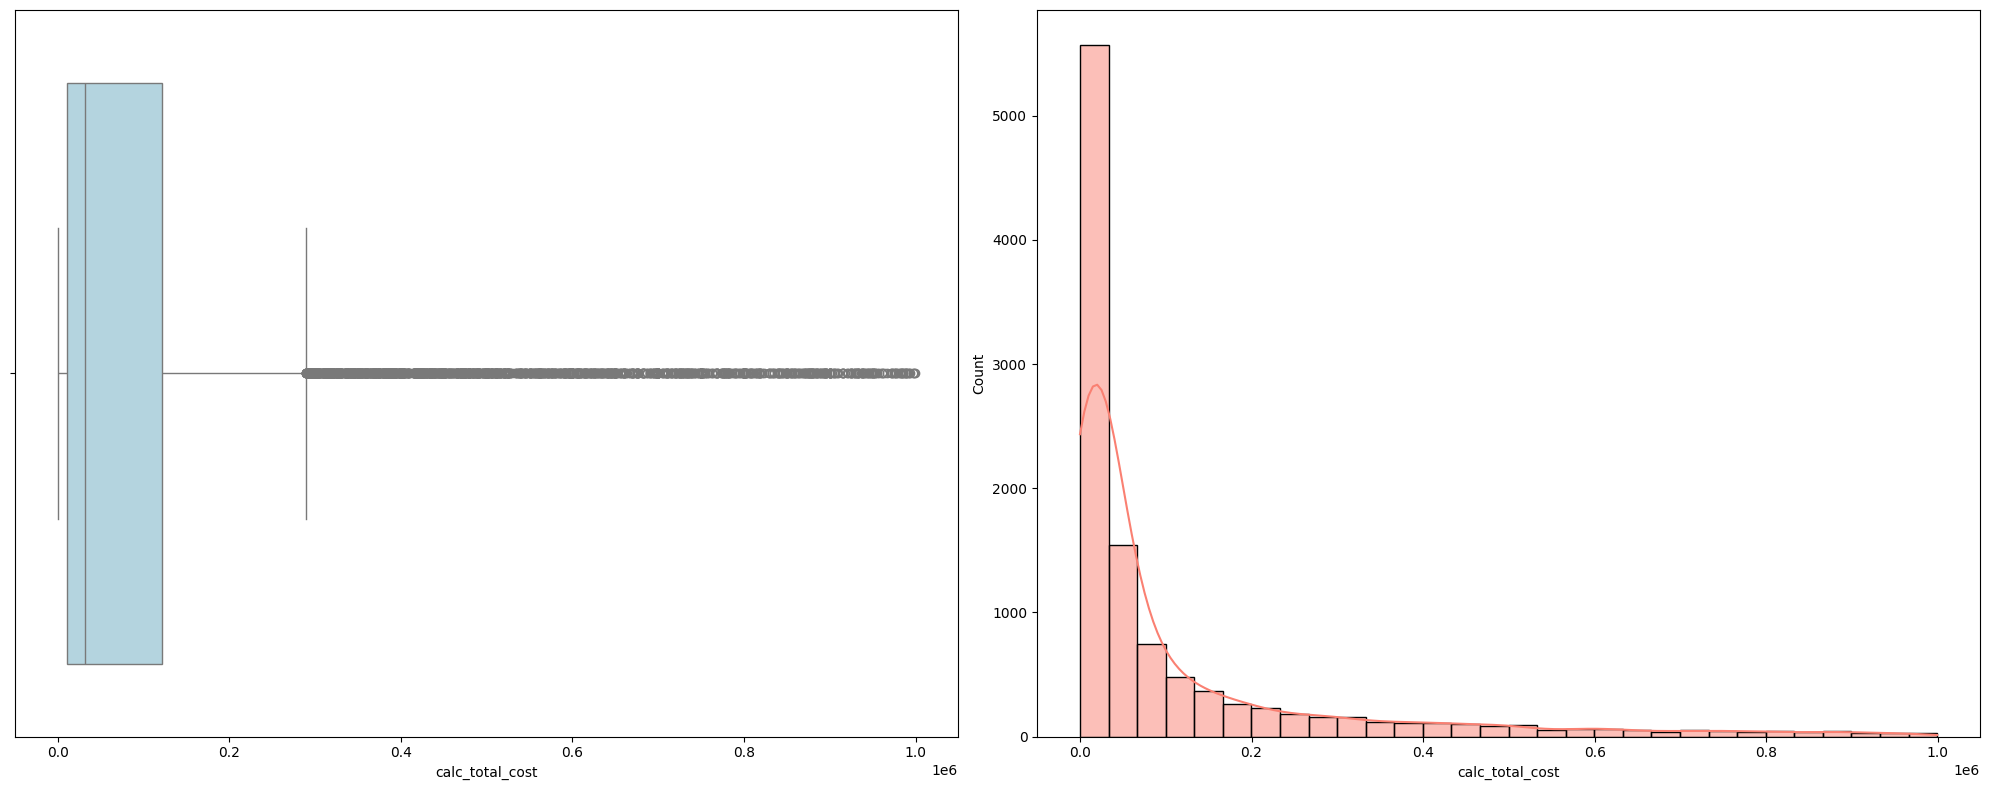

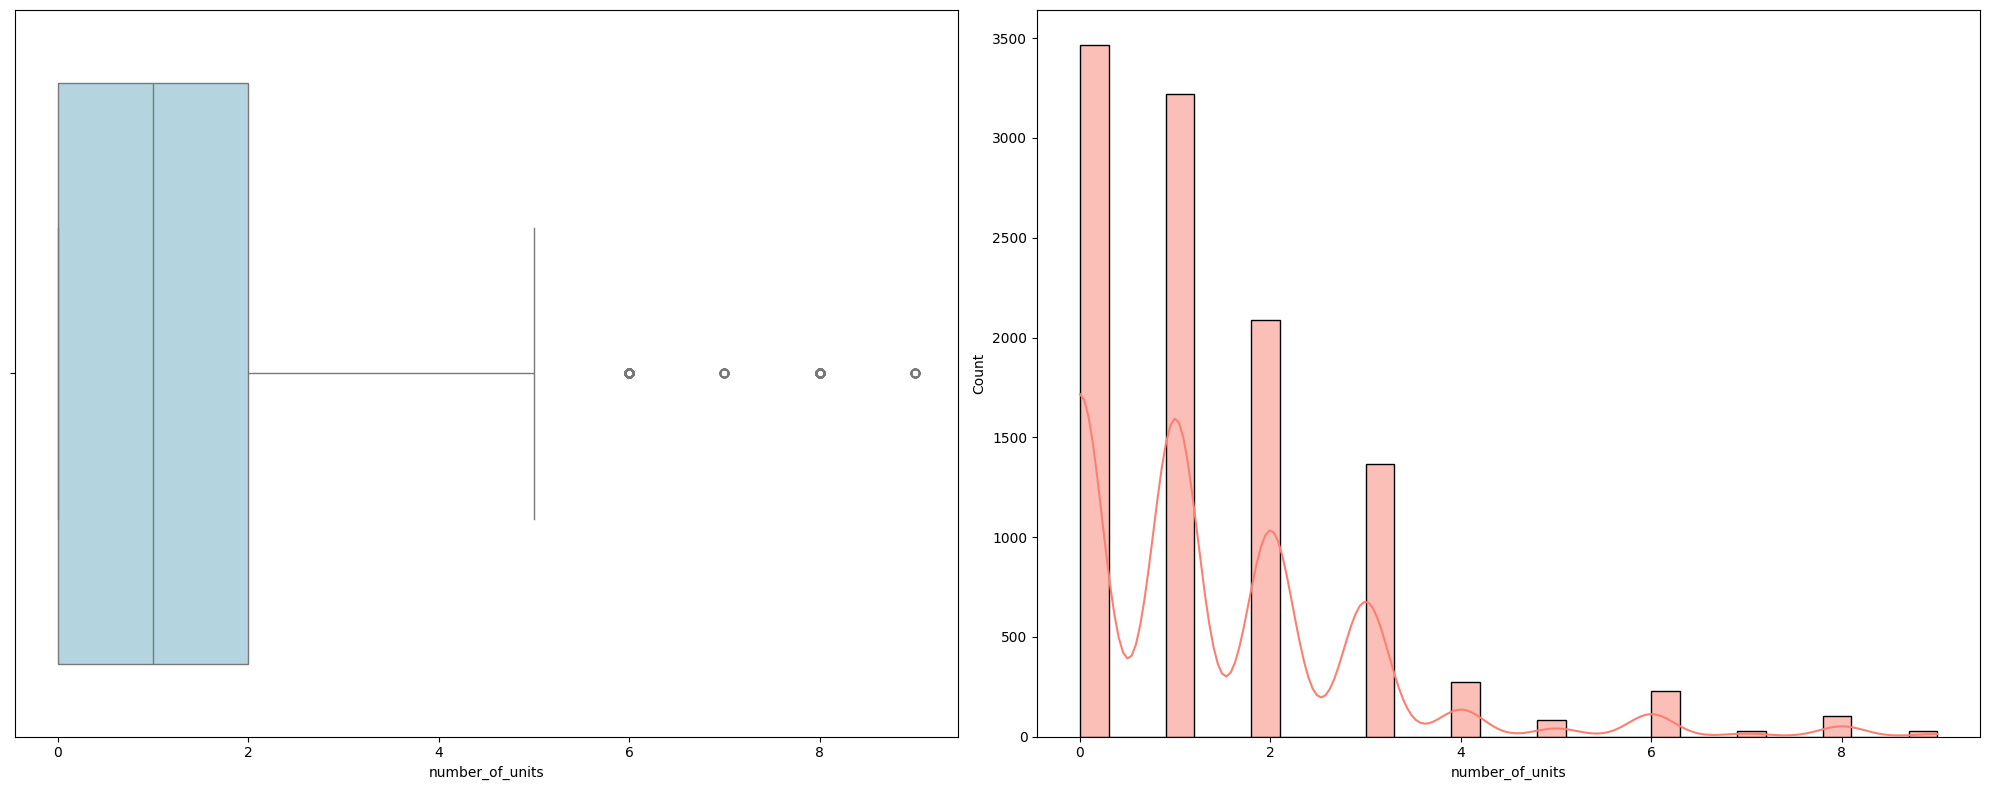

In [84]:
def plot_outliers(df, column):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.boxplot(x = df[column], color="lightblue", ax=ax1)
    sns.histplot(df[column], kde=True, bins=30, color="salmon", ax=ax2)
    plt.tight_layout()
    plt.show()

df_test_total_cost = df[df["calc_total_cost"] < 1000000]
df_test_number_of_units = df[(df["number_of_units"] < 10)]

testing_dict = {
    "calc_total_cost": df_test_total_cost, 
    "number_of_units": df_test_number_of_units
}

for key, value in testing_dict.items():
    plot_outliers(value, key)

#### Discretizing Features to include Outliers

In [85]:
# Discretizing 'total_cost' into 3 categories
bins = [0, 20000, 200000, 2000000, df['calc_total_cost'].max()]
labels = ["low", "medium", "high", "very high"]
df['total_cost_bins'] = pd.cut(df['calc_total_cost'], bins=bins, labels=labels, include_lowest=True)

df['total_cost_bins'].value_counts()

total_cost_bins
medium       4630
low          4371
high         2299
very high     570
Name: count, dtype: int64

In [86]:
# df = df[df["calc_total_cost"] > 10000000]
# df = df[df["number_of_units"] < 10]
df

,record_number,address,latitude,longitude,status,issue_date,number_of_units,current_property_use,building_cost,electrical_cost,...,building_use,condo_association,building_construction_type,bza_case,planning_board_special_permit,bicycle_parking_change,issue_year,Issue_month,calc_total_cost,total_cost_bins
0,62244,"304 Vassar St, Cambridge, MA 02139",42.354803,-71.104827,Active,2020-01-07,0.0,Not Specified,310000.0,85000.0,...,Commercial / Mixed Use,0,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2020,1,424600.0,high
1,62595,"174 Alewife Brook Pkwy, Cambridge, MA 02138",42.390588,-71.140620,Active,2019-12-23,0.0,Not Specified,10000.0,2000.0,...,Commercial / Mixed Use,0,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2019,12,16500.0,low
2,62708,"1493 Cambridge St, Cambridge, MA 02139",42.374425,-71.104437,Active,2020-01-10,0.0,Not Specified,34800.0,0.0,...,Commercial / Mixed Use,0,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2020,1,34800.0,medium
3,53472,"151 Magazine St, Cambridge, MA 02139",42.358092,-71.112429,Complete,2019-08-12,3.0,Multi-Family (3 units or greater),4000.0,0.0,...,Multi Family (3 or more dwelling units),1,Wood (Type (IV/V),0,0,False,2019,8,4000.0,low
4,53646,"292 Columbia St, Unit 2, Cambridge, MA 02141",42.370272,-71.095866,Active,2019-08-29,3.0,Multi-Family (3 units or greater),55000.0,0.0,...,Multi Family (3 or more dwelling units),0,Masonry / Wood (Type III),0,0,False,2019,8,55000.0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11873,60748,"105 Broadway, Cambridge, MA 02142",42.364383,-71.087858,Active,2019-11-20,0.0,Not Specified,101000.0,300000.0,...,Commercial / Mixed Use,0,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2019,11,586000.0,high
11874,61701,"377 Putnam Ave, Cambridge, Ma 02139",42.368296,-71.101828,Active,2019-12-26,0.0,Not Specified,3186000.0,214000.0,...,Commercial / Mixed Use,0,"Steel/Concrete, Non-Combustible (Type I/II)",1,1,False,2019,12,3400000.0,very high
11875,61881,"9 Brookline St, Cambridge, MA 02139",42.363788,-71.101715,Active,2020-01-13,0.0,Not Specified,9350.0,0.0,...,Commercial / Mixed Use,0,Masonry / Wood (Type III),0,0,False,2020,1,10200.0,low
11876,62039,"99 Magazine St, Unit 1, Cambridge, MA 02139",42.360474,-71.109815,Complete,2019-12-10,2.0,Two-Family,24551.0,1800.0,...,One or Two Family Dwelling,0,Wood (Type (IV/V),0,0,False,2019,12,32901.0,medium


In [87]:
# df[df["number_of_units"] == 0]

### Clean Firma Name's Typos

In [88]:
display(list(df["firm_name"].unique()))
df["firm_name"].nunique()

['Other',
 'TC Remodeling',
 'albert m stuart',
 'Steve E. Valenti Builders, Inc',
 'Jason Du Construction Co.',
 'renewal by Andersen',
 'Metro Insulation, Inc',
 'Renewal by Andersen',
 'Dan Han Construction',
 'keltic colors',
 'S+H Construction',
 'Rebel Builders',
 'New Boston builders',
 'Mass Weatherization',
 'Capital Construction',
 'Frank Mederios Contracting',
 'John P. Insulation',
 'M F Keane Contracting.com',
 'Lee Kennedy.com',
 'Simon',
 'M. Taylor Carpentry',
 'pella windows',
 'skanska',
 'Heffernan Build & Remodel',
 'thermpros inc',
 'Vertec Corp',
 'Eli ayash General Contractor',
 'Duca Construction',
 'NEWPRO',
 'Newmarket Properties',
 'C Burrell Contractors',
 'PIDC Construction LLC',
 'PIDC Construction',
 'jd property',
 'john dudley,,united home experts',
 'MD CONSTRUCTION',
 'LDC',
 'Lifetime Roofing LLC',
 'Neeeco LLC',
 'George Shaw',
 '5C Energy, Inc.',
 'Robicco Inc',
 'LMH Construction Group, LLC',
 'American Building Technologies',
 'Wise Construction'

4454

In [89]:
from firm_name_cleaner import clean_firm_names

In [90]:
df = clean_firm_names(df)


In [91]:
display(list(df["standardized_firm_name"].unique()))
df["standardized_firm_name"].nunique()

['Other',
 'TC Building Incorporated',
 'albert m stuart',
 'Steve E. Valenti Builders Inc.',
 'Jason Du Construction Co.',
 'Renewal by Ansdersen LLC',
 'retro tec insulation llc',
 'Dan Han Construction',
 'keltic colors of new england',
 'S and H construction',
 'Rebel Builders',
 'Boston Construction Group LLC',
 'Air tight Weatherization LLC.',
 'Capital Construction Contracting Inc.',
 'Frank Mederios Contracting Inc.',
 'Dolphin Insulation Inc',
 'M F Keane Contracting.com',
 'Lee Kennedy Company Inc.',
 'simon amin',
 'Macomber Carpentry & Construction LLC',
 'pella windows',
 'Skanska USA Building Inc.',
 'Heffernan Build & Remodel Inc.',
 'thermpros inc',
 'Vertec Corp.',
 'All Matters General Contractor Inc',
 'Duncan Builders LLC',
 'NEWPRO',
 'Newmarket Properties',
 'C Burrell Contractors',
 'PIDC Construction LLC.',
 'JAD CONTRACTING LLC',
 'john dudleyunited home experts',
 'MDH Construction',
 'LC Construction Inc',
 'Lifetime Roofing LLC',
 'Neeeco LLC',
 'George Shaw

2190

In [92]:
display(df[['original_firm_name', 'firm_name', 'standardized_firm_name']].head(50))

,original_firm_name,firm_name,standardized_firm_name
0,Other,Other,Other
1,TC Remodeling,TC Remodeling,TC Building Incorporated
2,albert m stuart,albert m stuart,albert m stuart
3,"Steve E. Valenti Builders, Inc",Steve E. Valenti Builders Inc,Steve E. Valenti Builders Inc.
4,Jason Du Construction Co.,Jason Du Construction Co.,Jason Du Construction Co.
5,Other,Other,Other
6,renewal by Andersen,renewal by Andersen,Renewal by Ansdersen LLC
7,"Metro Insulation, Inc",Metro Insulation Inc,retro tec insulation llc
8,Renewal by Andersen,Renewal by Andersen,Renewal by Ansdersen LLC
9,Dan Han Construction,Dan Han Construction,Dan Han Construction


### Convert Description into a soup of words

In [132]:
from tqdm.auto import tqdm

nlp = spacy.load('en_core_web_sm')

# def extract_keywords_with_context(text):
#     """
#     Extract keywords from text using spaCy while preserving adjective-noun relationships
    
#     Args:
#         text (str): Input text
        
#     Returns:
#         list: List of extracted keywords and phrases
#     """
#     # Handle NaN values
#     if pd.isna(text) or text == '':
#         return []
    
#     # Clean text
#     text = re.sub(r'\s+', ' ', str(text).strip())
    
#     # Process with spaCy
#     doc = nlp(text)
    
#     keywords = []
    
#     # First pass: Identify noun chunks (phrases)
#     for chunk in doc.noun_chunks:
#         # Filter out chunks containing only stop words
#         if not all(token.is_stop for token in chunk):
#             # Clean the chunk text
#             clean_chunk = ' '.join([token.lemma_.lower() for token in chunk 
#                                    if not token.is_punct and len(token.text) > 1])
#             if clean_chunk and len(clean_chunk) > 2:
#                 keywords.append(clean_chunk)
    
#     # Second pass: Find adjectives connected to verbs
#     for token in doc:
#         if token.pos_ == 'ADJ':
#             # Check if this adjective modifies a verb
#             head = token.head
#             if head.pos_ == 'VERB' and not head.is_stop:
#                 # Create adjective + verb phrase
#                 adj_verb_phrase = f"{token.lemma_.lower()} {head.lemma_.lower()}"
#                 if adj_verb_phrase not in keywords and len(adj_verb_phrase) > 2:
#                     keywords.append(adj_verb_phrase)
    
#     # Third pass: Capture important standalone terms that aren't already in phrases
#     for token in doc:
#         # Check for standalone important terms (nouns, proper nouns, verbs)
#         if token.pos_ in ['NOUN', 'PROPN', 'VERB']:
#             # Filter out stop words and short words
#             if not token.is_stop and len(token.text) > 2:
#                 # Check if this term is not already part of an extracted chunk
#                 term = token.lemma_.lower()
#                 if not any(term in chunk for chunk in keywords):
#                     keywords.append(term)
    
#     # Remove duplicates while maintaining order
#     unique_keywords = []
#     for keyword in keywords:
#         if keyword not in unique_keywords:
#             unique_keywords.append(keyword)
    
#     return unique_keywords

# def process_dataframe(df, description_col='description'):
#     """
#     Process a dataframe to extract keywords from a description column
    
#     Args:
#         df (pandas.DataFrame): Input dataframe
#         description_col (str): Name of the description column
        
#     Returns:
#         pandas.DataFrame: DataFrame with added keywords column
#     """
#     # Check if the description column exists
#     if description_col not in df.columns:
#         raise ValueError(f"Column '{description_col}' not found in dataframe")
    
#     # Make a copy to avoid modifying the original
#     result_df = df.copy()
    
#     # Extract keywords for each row with progress bar
#     print(f"Extracting keywords from '{description_col}' column...")
#     result_df['keywords'] = [extract_keywords_with_context(text) for text in tqdm(result_df[description_col].tolist())]
    
#     print(f"Keyword extraction complete. Added 'keywords' column.")
#     return result_df

# def extract_keywords_with_context(text):
#     """
#     Extract meaningful keyword phrases from text using spaCy
    
#     Args:
#         text (str): Input text
        
#     Returns:
#         list: List of extracted meaningful keyword phrases
#     """
#     # Handle NaN values
#     if pd.isna(text) or text == '':
#         return []
    
#     # Clean text
#     text = re.sub(r'\s+', ' ', str(text).strip())
    
#     # Process with spaCy
#     doc = nlp(text)
    
#     keywords = []
    
#     # Extract noun phrases (adj+noun, noun+noun combinations)
#     for chunk in doc.noun_chunks:
#         # Skip chunks with only stopwords or too long phrases
#         if all(token.is_stop for token in chunk) or len(chunk) > 4:
#             continue
            
#         # Clean and filter tokens in chunk
#         clean_tokens = []
#         for token in chunk:
#             # Keep only meaningful parts (adjectives, nouns, and some verbs)
#             if token.pos_ in ['NOUN', 'PROPN', 'ADJ'] and not token.is_punct and len(token.text) > 1:
#                 clean_tokens.append(token.lemma_.lower())
        
#         # Create clean phrase if it has 1-3 words
#         if 1 <= len(clean_tokens) <= 3:
#             clean_phrase = ' '.join(clean_tokens)
#             if len(clean_phrase) > 2:
#                 keywords.append(clean_phrase)
    
#     # Find meaningful verb+noun or adj+verb combinations
#     for token in doc:
#         if token.pos_ in ['VERB', 'ADJ']:
#             for child in token.children:
#                 # Look for verb+noun or adj+noun combinations
#                 if (token.pos_ == 'VERB' and child.pos_ in ['NOUN', 'PROPN']) or \
#                    (token.pos_ == 'ADJ' and child.pos_ == 'VERB'):
#                     if not token.is_stop and not child.is_stop:
#                         # Create 2-word phrase
#                         phrase = f"{token.lemma_.lower()} {child.lemma_.lower()}"
#                         if phrase not in keywords and len(phrase) > 2:
#                             keywords.append(phrase)
    
#     # Extract meaningful single words (only nouns and proper nouns)
#     # but only if they're not already part of a phrase
#     for token in doc:
#         if token.pos_ in ['NOUN', 'PROPN'] and not token.is_stop and len(token.text) > 2:
#             term = token.lemma_.lower()
#             # Check if this term is not already part of an extracted phrase
#             if not any(term in phrase for phrase in keywords):
#                 keywords.append(term)
    
#     # Remove duplicates while maintaining order
#     unique_keywords = []
#     for keyword in keywords:
#         if keyword not in unique_keywords:
#             unique_keywords.append(keyword)
    
#     return unique_keywords

# def process_dataframe(df, description_col='description', id_col=None):
#     """
#     Process a dataframe to extract keywords from a description column
    
#     Args:
#         df (pandas.DataFrame): Input dataframe
#         description_col (str): Name of the description column
#         id_col (str, optional): Name of the ID column. If None, uses dataframe index.
        
#     Returns:
#         pandas.DataFrame: DataFrame with added keywords column
#     """
#     # Check if the description column exists
#     if description_col not in df.columns:
#         raise ValueError(f"Column '{description_col}' not found in dataframe")
    
#     # Make a copy to avoid modifying the original
#     result_df = df.copy()
    
#     # Add record_number column if id_col is not specified
#     if id_col is None:
#         result_df['record_number'] = result_df.index
#     else:
#         if id_col not in df.columns:
#             raise ValueError(f"ID column '{id_col}' not found in dataframe")
#         result_df['record_number'] = result_df[id_col]
    
#     # Extract keywords for each row with progress bar
#     print(f"Extracting keywords from '{description_col}' column...")
#     result_df['keywords'] = [extract_keywords_with_context(text) for text in tqdm(result_df[description_col].tolist())]
    
#     print(f"Keyword extraction complete. Added 'keywords' column.")
#     return result_df

def clean_text(text):
    """
    Clean and preprocess text before keyword extraction
    
    Args:
        text (str): Input text
        
    Returns:
        str: Cleaned text
    """
    # Handle NaN values
    if pd.isna(text) or text == '':
        return ''
    
    # Fix spacing
    text = re.sub(r'\s+', ' ', str(text).strip())
    
    # Fix common typos
    text = text.replace("wityh", "with")
    
    # Remove parentheses and other problematic characters
    text = re.sub(r'[\(\)]', ' ', text)
    
    # Clean up numbers followed by single characters
    text = re.sub(r'(\d+)\s+([a-zA-Z])\s', r'\1\2 ', text)
    
    return text

def extract_keywords_with_context(text):
    """
    Extract meaningful keyword phrases from construction/repair text using spaCy
    
    Args:
        text (str): Input text
        
    Returns:
        list: List of extracted meaningful keyword phrases
    """
    # Clean text
    text = clean_text(text)
    if not text:
        return []
    
    # Process with spaCy
    doc = nlp(text)
    
    keywords = []
    
    # Extract verb phrases with their objects (install wall, replace floor)
    keywords.extend(extract_construction_verb_phrases(doc))
    
    # Extract material + component combinations (metal stud, wood floor)
    keywords.extend(extract_material_component_combinations(doc))
    
    # Extract measurements with context (5/8 fire, 3 kw)
    keywords.extend(extract_measurements_with_context(doc))
    
    # Extract important noun phrases (kitchen floor, hood vent)
    keywords.extend(extract_noun_phrases(doc))
    
    # Extract important compound terms (noun+noun combinations)
    keywords.extend(extract_compound_terms(doc))
    
    # Final cleanup and filtering
    final_keywords = filter_and_clean_keywords(keywords)
    
    return final_keywords

def extract_construction_verb_phrases(doc):
    """Extract verb phrases related to construction/repair"""
    keywords = []
    construction_verbs = ['install', 'replace', 'repair', 'remove', 'build', 'construct']
    
    for token in doc:
        if token.lemma_.lower() in construction_verbs:
            # Find all noun phrases that are children of this verb
            obj_tokens = []
            for child in token.children:
                if child.pos_ in ['NOUN', 'PROPN']:
                    # Include modifiers of this noun
                    modifiers = []
                    for modifier in child.children:
                        if modifier.pos_ in ['ADJ', 'NOUN', 'PROPN'] or modifier.dep_ == 'compound':
                            modifiers.append(modifier.text.lower())
                    
                    # Create phrase with modifiers + noun
                    if modifiers:
                        phrase = ' '.join(modifiers) + ' ' + child.text.lower()
                    else:
                        phrase = child.text.lower()
                    
                    obj_tokens.append(phrase)
            
            # Create construction action phrases
            for obj in obj_tokens:
                action_phrase = f"{token.lemma_.lower()} {obj}"
                if action_phrase not in keywords:
                    keywords.append(action_phrase)
                    
    return keywords

def extract_material_component_combinations(doc):
    """Extract material + component combinations"""
    keywords = []
    material_words = ['metal', 'wood', 'vinyl', 'plastic', 'steel', 'aluminum', 'fire']
    component_words = ['stud', 'wall', 'floor', 'ceiling', 'door', 'window', 'vent', 'hood', 'cabinet', 'heat']
    
    # Find material + component combinations
    for i, token in enumerate(doc):
        if token.lemma_.lower() in material_words:
            # Look ahead for component words
            for j in range(i+1, min(i+4, len(doc))):
                if doc[j].lemma_.lower() in component_words:
                    material_component = f"{token.lemma_.lower()} {doc[j].lemma_.lower()}"
                    if material_component not in keywords:
                        keywords.append(material_component)
                        
    return keywords

def extract_measurements_with_context(doc):
    """Extract measurements with their context"""
    keywords = []
    measurement_pattern = re.compile(r'\d+/\d+|\d+\.\d+|\d+')
    
    for i, token in enumerate(doc):
        if measurement_pattern.match(token.text):
            # Check if next token is a unit or material
            if i < len(doc) - 1:
                # Skip single characters or stopwords as the next token
                if len(doc[i+1].text) <= 1 or doc[i+1].is_stop:
                    continue
                
                measurement = f"{token.text} {doc[i+1].text.lower()}"
                if measurement not in keywords:
                    keywords.append(measurement)
                    
    return keywords

def extract_noun_phrases(doc):
    """Extract important noun phrases"""
    keywords = []
    
    for chunk in doc.noun_chunks:
        # Skip chunks with only stopwords
        if all(token.is_stop for token in chunk):
            continue
            
        # Extract clean noun phrases
        if 2 <= len(chunk) <= 3:
            clean_phrase = ' '.join([token.lemma_.lower() for token in chunk 
                                    if not token.is_punct and len(token.text) > 1 
                                    and not token.is_stop])
            if clean_phrase and len(clean_phrase) > 2 and clean_phrase not in keywords:
                keywords.append(clean_phrase)
                
    return keywords

def extract_compound_terms(doc):
    """Extract compound terms (noun+noun combinations)"""
    keywords = []
    
    for i in range(len(doc) - 1):
        if doc[i].pos_ in ['NOUN', 'PROPN'] and doc[i+1].pos_ in ['NOUN', 'PROPN']:
            if not doc[i].is_stop and not doc[i+1].is_stop:
                compound = f"{doc[i].lemma_.lower()} {doc[i+1].lemma_.lower()}"
                if compound not in keywords:
                    keywords.append(compound)
                    
    return keywords

def filter_and_clean_keywords(keywords):
    """Final filtering and cleaning of keywords"""
    final_keywords = []
    
    for keyword in keywords:
        # Skip single words that are too short
        words = keyword.split()
        if len(words) == 1 and len(keyword) <= 2:
            continue
            
        # Skip phrases with single characters or parentheses
        if re.search(r'\b[a-zA-Z]\b|\(|\)', keyword):
            continue
            
        # Skip phrases with only numbers and single characters
        if re.match(r'^\d+\s+[a-zA-Z]$', keyword):
            continue
            
        # Check if this keyword is a subset of an existing keyword
        if not any(keyword in k and keyword != k for k in keywords):
            final_keywords.append(keyword)
    
    return final_keywords

def process_dataframe(df, description_col='description', id_col=None):
    """
    Process a dataframe to extract keywords from a description column
    
    Args:
        df (pandas.DataFrame): Input dataframe
        description_col (str): Name of the description column
        id_col (str, optional): Name of the ID column. If None, uses dataframe index.
        
    Returns:
        pandas.DataFrame: DataFrame with added keywords column
    """
    # Check if the description column exists
    if description_col not in df.columns:
        raise ValueError(f"Column '{description_col}' not found in dataframe")
    
    # Make a copy to avoid modifying the original
    result_df = df.copy()
    
    # Add record_number column if id_col is not specified
    if id_col is None:
        result_df['record_number'] = result_df.index
    else:
        if id_col not in df.columns:
            raise ValueError(f"ID column '{id_col}' not found in dataframe")
        result_df['record_number'] = result_df[id_col]
    
    # Extract keywords for each row with progress bar
    print(f"Extracting keywords from '{description_col}' column...")
    result_df['keywords'] = [extract_keywords_with_context(text) for text in tqdm(result_df[description_col].tolist())]
    
    print(f"Keyword extraction complete. Added 'keywords' column.")
    return result_df

In [133]:
df = process_dataframe(df, description_col='description')
df

Extracting keywords from 'description' column...


  0%|          | 0/11870 [00:00<?, ?it/s]

Keyword extraction complete. Added 'keywords' column.


,record_number,address,latitude,longitude,status,issue_date,number_of_units,current_property_use,building_cost,electrical_cost,...,bza_case,planning_board_special_permit,bicycle_parking_change,issue_year,Issue_month,calc_total_cost,total_cost_bins,original_firm_name,standardized_firm_name,keywords
0,0,"304 Vassar St, Cambridge, MA 02139",42.354803,-71.104827,Active,2020-01-07,0.0,Not Specified,310000.0,85000.0,...,0,0,False,2020,1,424600.0,high,Other,Other,"[repair build finishes out, complete interior,..."
1,1,"174 Alewife Brook Pkwy, Cambridge, MA 02138",42.390588,-71.140620,Active,2019-12-23,0.0,Not Specified,10000.0,2000.0,...,0,0,False,2019,12,16500.0,low,TC Remodeling,TC Building Incorporated,[interior wall]
2,2,"1493 Cambridge St, Cambridge, MA 02139",42.374425,-71.104437,Active,2020-01-10,0.0,Not Specified,34800.0,0.0,...,0,0,False,2020,1,34800.0,medium,albert m stuart,albert m stuart,"[fire door, damaged door, fire door]"
3,3,"151 Magazine St, Cambridge, MA 02139",42.358092,-71.112429,Complete,2019-08-12,3.0,Multi-Family (3 units or greater),4000.0,0.0,...,0,0,False,2019,8,4000.0,low,"Steve E. Valenti Builders, Inc",Steve E. Valenti Builders Inc.,"[replace front porch rail stair, porch stair, ..."
4,4,"292 Columbia St, Unit 2, Cambridge, MA 02141",42.370272,-71.095866,Active,2019-08-29,3.0,Multi-Family (3 units or greater),55000.0,0.0,...,0,0,False,2019,8,55000.0,medium,Jason Du Construction Co.,Jason Du Construction Co.,"[kitchen renovation, wall finishing, kitchen r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11873,11873,"105 Broadway, Cambridge, MA 02142",42.364383,-71.087858,Active,2019-11-20,0.0,Not Specified,101000.0,300000.0,...,0,0,False,2019,11,586000.0,high,"Architectural Environments, Inc.",Architectural Building & Restoration LLC,"[penthouse emergency, emergency generator]"
11874,11874,"377 Putnam Ave, Cambridge, Ma 02139",42.368296,-71.101828,Active,2019-12-26,0.0,Not Specified,3186000.0,214000.0,...,1,1,False,2019,12,3400000.0,very high,"McCourt Construction Company, Inc.",McCourt Construction Company Inc.,"[concrete foundation, new transformer, ornamen..."
11875,11875,"9 Brookline St, Cambridge, MA 02139",42.363788,-71.101715,Active,2020-01-13,0.0,Not Specified,9350.0,0.0,...,0,0,False,2020,1,10200.0,low,bna,BNA CONTRACTING INC.,"[install metal stud wall, replace kitchen floo..."
11876,11876,"99 Magazine St, Unit 1, Cambridge, MA 02139",42.360474,-71.109815,Complete,2019-12-10,2.0,Two-Family,24551.0,1800.0,...,0,0,False,2019,12,32901.0,medium,"Gilman, Guidelli & Bellow",Gilman Guidelli & Bellow Co. Inc.,"[exist bathroom, new plumbing fixture, locatio..."


In [134]:
def create_keyword_dataframe(df_with_keywords):
    """
    Create a new dataframe where each keyword is in a separate row
    
    Args:
        df_with_keywords (pandas.DataFrame): Dataframe with 'keywords' column (list of keywords)
                                            and 'record_number' column
    
    Returns:
        pandas.DataFrame: Long-format dataframe with one keyword per row
    """
    if 'keywords' not in df_with_keywords.columns:
        raise ValueError("Column 'keywords' not found in dataframe")
    
    if 'record_number' not in df_with_keywords.columns:
        raise ValueError("Column 'record_number' not found in dataframe")
    
    # Create empty list to store keyword records
    keyword_records = []
    
    # Iterate through each row in the original dataframe
    for _, row in df_with_keywords.iterrows():
        record_number = row['record_number']
        
        # Add each keyword as a separate record
        for keyword in row['keywords']:
            keyword_records.append({
                'record_number': record_number,
                'keyword': keyword
            })
    
    # Create the keyword dataframe
    keyword_df = pd.DataFrame(keyword_records)
    
    print(f"Created keyword dataframe with {len(keyword_df)} rows.")
    return keyword_df

In [135]:
keyword_df = create_keyword_dataframe(df)

Created keyword dataframe with 74100 rows.


In [139]:
# Display the keyword dataframe
print("\nKeyword dataframe sample:")
display(keyword_df.head(50))


Keyword dataframe sample:


,record_number,keyword
0,0,repair build finishes out
1,0,complete interior
2,0,limited exterior renovation
3,0,story masonry
4,0,masonry building
5,0,masonry repair
6,1,interior wall
7,2,fire door
8,2,damaged door
9,2,fire door


In [137]:
np.array(df[df["record_number"] == 11875][["description", "keywords"]])

array([['install a metal stud wall wityh 5/8 fire code for repair of hood vent, replace kitchen floor',
        list(['install metal stud wall', 'replace kitchen floor', 'metal wall', '5/8 fire code', 'hood vent', 'hood vent'])]],
      dtype=object)

In [140]:
display(keyword_df.tail(50))

,record_number,keyword
74050,11869,replace tops cabinets
74051,11869,install recess lights
74052,11869,install splash
74053,11869,replace dishwasher stove
74054,11869,exist cabinet
74055,11869,counter top
74056,11869,wall
74057,11869,counter top
74058,11870,40 kw
74059,11870,heat


In [143]:
keyword_df["keyword"].value_counts().head(50)

keyword
air sealing            807
insulation work        603
structural change      584
site id                483
2nd floor              398
fire alarm             373
mass save              372
1st floor              361
save program           355
structural work        339
interior renovation    338
3rd floor              296
replacement window     284
bathroom renovation    254
fire protection        244
replace windows        239
living room            234
office space           226
project                193
bathroom               192
kitchen cabinet        191
floor                  190
new finish             176
kitchen renovation     176
exterior wall          169
new window             169
second floor           165
building               164
floor bathroom         158
exist bathroom         148
interior demolition    133
gut renovation         128
bathroom remodel       127
exist window           126
exist kitchen          126
new kitchen            124
energy star         

In [ ]:
# Add frequency count to keywords
keyword_counts = keyword_df['keyword'].value_counts().reset_index()
keyword_counts.columns = ['keyword', 'frequency']

# Merge to add frequency to each keyword instance
keyword_df_with_freq = pd.merge(keyword_df, keyword_counts, on='keyword', how='left')

# Export keyword dataframe
keyword_df_with_freq.to_csv("../data/clean/keyword_data.csv", index=False)
print(f"Keyword dataframe exported with {len(keyword_df_with_freq)} rows.")

# 3. Create a summary file with unique keywords and their frequencies for the word cloud
unique_keywords = keyword_counts.copy()
unique_keywords.to_csv("../data/clean/unique_keywords.csv", index=False)

### Equalize Current Property Use and Building Use

In [ ]:
df = df[(df["current_property_use"] != 'Vacant Lot') & (df["current_property_use"] != 'Accessory')]

In [ ]:
print(df["current_property_use"].unique())
print(df["building_use"].unique())

['Not Specified' 'Multi-Family (3 units or greater)' 'Townhouse'
 'One-Family' 'Two-Family' 'Commercial / Mixed Use']
['Commercial / Mixed Use' 'Multi Family (3 or more dwelling units)'
 'One or Two Family Dwelling' 'Townhouse']


In [ ]:
building_use_dict = {
    "Not Specified": "Commercial/Mixed",
    "Commercial / Mixed Use": "Commercial/Mixed",

    "Multi-Family (3 units or greater)": "Multi-Family",
    "Multi Family (3 or more dwelling units)": "Multi-Family",

    'Two-Family': 'One/Two-Family',
    'One-Family': 'One/Two-Family',
    'One or Two Family Dwelling': 'One/Two-Family',

    'Townhouse': 'Townhouse',
}

df = df.replace({"current_property_use": building_use_dict})
df = df.replace({"building_use": building_use_dict})

df[["current_property_use", "building_use"]]

,current_property_use,building_use
0,Commercial/Mixed,Commercial/Mixed
1,Commercial/Mixed,Commercial/Mixed
2,Commercial/Mixed,Commercial/Mixed
3,Multi-Family,Multi-Family
4,Multi-Family,Multi-Family
...,...,...
11873,Commercial/Mixed,Commercial/Mixed
11874,Commercial/Mixed,Commercial/Mixed
11875,Commercial/Mixed,Commercial/Mixed
11876,One/Two-Family,One/Two-Family


### Last Checks

In [ ]:
df.columns

Index(['record_number', 'address', 'latitude', 'longitude', 'status',
       'issue_date', 'number_of_units', 'current_property_use',
       'building_cost', 'electrical_cost', 'plumbing_cost', 'gas_cost',
       'hvac_cost', 'total_cost', 'fire_prevention_cost', 'description',
       'isd_description', 'size_of_new_addition',
       'change_in_floor_area_or_dimensions', 'change_in_exterior',
       'discharge_to_sewer_or_storm_water_system',
       'new_or_replaced_storm_sewer', 'construction_dewatering',
       'public_right-of-way', 'basement_plumbing_fixture',
       'change_in_at_least_half_of_total_area', 'firm_name', 'debris_disposal',
       'description_of_demolition', 'method_of_removal', 'type_of_demolition',
       'building_use', 'condo_association', 'building_construction_type',
       'bza_case', 'planning_board_special_permit', 'bicycle_parking_change',
       'issue_year', 'Issue_month', 'calc_total_cost', 'total_cost_bins',
       'original_firm_name', 'standardized_f

In [ ]:
df.dtypes

record_number                                        int64
address                                             object
latitude                                           float64
longitude                                          float64
status                                              object
issue_date                                  datetime64[ns]
number_of_units                                    float64
current_property_use                                object
building_cost                                      float64
electrical_cost                                    float64
plumbing_cost                                      float64
gas_cost                                           float64
hvac_cost                                          float64
total_cost                                         float64
fire_prevention_cost                               float64
description                                         object
isd_description                                     obje

In [ ]:
df

,record_number,address,latitude,longitude,status,issue_date,number_of_units,current_property_use,building_cost,electrical_cost,...,building_construction_type,bza_case,planning_board_special_permit,bicycle_parking_change,issue_year,Issue_month,calc_total_cost,total_cost_bins,original_firm_name,standardized_firm_name
0,62244,"304 Vassar St, Cambridge, MA 02139",42.354803,-71.104827,Active,2020-01-07,0.0,Commercial/Mixed,310000.0,85000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2020,1,424600.0,high,Other,Other
1,62595,"174 Alewife Brook Pkwy, Cambridge, MA 02138",42.390588,-71.140620,Active,2019-12-23,0.0,Commercial/Mixed,10000.0,2000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2019,12,16500.0,low,TC Remodeling,TC Building Incorporated
2,62708,"1493 Cambridge St, Cambridge, MA 02139",42.374425,-71.104437,Active,2020-01-10,0.0,Commercial/Mixed,34800.0,0.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2020,1,34800.0,medium,albert m stuart,albert m stuart
3,53472,"151 Magazine St, Cambridge, MA 02139",42.358092,-71.112429,Complete,2019-08-12,3.0,Multi-Family,4000.0,0.0,...,Wood (Type (IV/V),0,0,False,2019,8,4000.0,low,"Steve E. Valenti Builders, Inc",Steve E. Valenti Builders Inc.
4,53646,"292 Columbia St, Unit 2, Cambridge, MA 02141",42.370272,-71.095866,Active,2019-08-29,3.0,Multi-Family,55000.0,0.0,...,Masonry / Wood (Type III),0,0,False,2019,8,55000.0,medium,Jason Du Construction Co.,Jason Du Construction Co.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11873,60748,"105 Broadway, Cambridge, MA 02142",42.364383,-71.087858,Active,2019-11-20,0.0,Commercial/Mixed,101000.0,300000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2019,11,586000.0,high,"Architectural Environments, Inc.",Architectural Building & Restoration LLC
11874,61701,"377 Putnam Ave, Cambridge, Ma 02139",42.368296,-71.101828,Active,2019-12-26,0.0,Commercial/Mixed,3186000.0,214000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",1,1,False,2019,12,3400000.0,very high,"McCourt Construction Company, Inc.",McCourt Construction Company Inc.
11875,61881,"9 Brookline St, Cambridge, MA 02139",42.363788,-71.101715,Active,2020-01-13,0.0,Commercial/Mixed,9350.0,0.0,...,Masonry / Wood (Type III),0,0,False,2020,1,10200.0,low,bna,BNA CONTRACTING INC.
11876,62039,"99 Magazine St, Unit 1, Cambridge, MA 02139",42.360474,-71.109815,Complete,2019-12-10,2.0,One/Two-Family,24551.0,1800.0,...,Wood (Type (IV/V),0,0,False,2019,12,32901.0,medium,"Gilman, Guidelli & Bellow",Gilman Guidelli & Bellow Co. Inc.


In [ ]:
df.reset_index(drop=True)

,record_number,address,latitude,longitude,status,issue_date,number_of_units,current_property_use,building_cost,electrical_cost,...,building_construction_type,bza_case,planning_board_special_permit,bicycle_parking_change,issue_year,Issue_month,calc_total_cost,total_cost_bins,original_firm_name,standardized_firm_name
0,62244,"304 Vassar St, Cambridge, MA 02139",42.354803,-71.104827,Active,2020-01-07,0.0,Commercial/Mixed,310000.0,85000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2020,1,424600.0,high,Other,Other
1,62595,"174 Alewife Brook Pkwy, Cambridge, MA 02138",42.390588,-71.140620,Active,2019-12-23,0.0,Commercial/Mixed,10000.0,2000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2019,12,16500.0,low,TC Remodeling,TC Building Incorporated
2,62708,"1493 Cambridge St, Cambridge, MA 02139",42.374425,-71.104437,Active,2020-01-10,0.0,Commercial/Mixed,34800.0,0.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2020,1,34800.0,medium,albert m stuart,albert m stuart
3,53472,"151 Magazine St, Cambridge, MA 02139",42.358092,-71.112429,Complete,2019-08-12,3.0,Multi-Family,4000.0,0.0,...,Wood (Type (IV/V),0,0,False,2019,8,4000.0,low,"Steve E. Valenti Builders, Inc",Steve E. Valenti Builders Inc.
4,53646,"292 Columbia St, Unit 2, Cambridge, MA 02141",42.370272,-71.095866,Active,2019-08-29,3.0,Multi-Family,55000.0,0.0,...,Masonry / Wood (Type III),0,0,False,2019,8,55000.0,medium,Jason Du Construction Co.,Jason Du Construction Co.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11846,60748,"105 Broadway, Cambridge, MA 02142",42.364383,-71.087858,Active,2019-11-20,0.0,Commercial/Mixed,101000.0,300000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",0,0,False,2019,11,586000.0,high,"Architectural Environments, Inc.",Architectural Building & Restoration LLC
11847,61701,"377 Putnam Ave, Cambridge, Ma 02139",42.368296,-71.101828,Active,2019-12-26,0.0,Commercial/Mixed,3186000.0,214000.0,...,"Steel/Concrete, Non-Combustible (Type I/II)",1,1,False,2019,12,3400000.0,very high,"McCourt Construction Company, Inc.",McCourt Construction Company Inc.
11848,61881,"9 Brookline St, Cambridge, MA 02139",42.363788,-71.101715,Active,2020-01-13,0.0,Commercial/Mixed,9350.0,0.0,...,Masonry / Wood (Type III),0,0,False,2020,1,10200.0,low,bna,BNA CONTRACTING INC.
11849,62039,"99 Magazine St, Unit 1, Cambridge, MA 02139",42.360474,-71.109815,Complete,2019-12-10,2.0,One/Two-Family,24551.0,1800.0,...,Wood (Type (IV/V),0,0,False,2019,12,32901.0,medium,"Gilman, Guidelli & Bellow",Gilman Guidelli & Bellow Co. Inc.


### Saving clean DataFrame as csv

In [ ]:
df.to_csv("../data/clean/building_permits_addition_alteration_clean.csv", index=False)